In [ ]:
import torchvision.transforms.v2 as transforms 
from torchvision import datasets, tv_tensors
from torch.utils.data import DataLoader
from PIL import ImageFilter
from PIL import Image
import numpy as np
import cv2

import os 
class EdgeEnhance(object):
    def __call__(self, image):
        # You can experiment between EDGE_ENHANCE and FIND_EDGES
        return image.filter(ImageFilter.EDGE_ENHANCE)
class EdgeDetectionTransform:
    def __call__(self, img):
        img = np.array(img)
        edges = cv2.Canny(img, 100, 200)  # Canny Edge Detection
        return Image.fromarray(edges)

class SharpenTransform:
    def __call__(self, img):
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])  # Sharpening kernel
        img = cv2.filter2D(np.array(img), -1, kernel)
        return Image.fromarray(img)

def get_data_loader(dir, config, mode):
    transform_list = []
    base_transform = None
    #test, val
    if mode in ("test", "val"):
        transform_list = [
            transforms.Resize(config['resize']),
            transforms.ToTensor(),
        ]
        if config.get("normalize", 0):
            transform_list.append(transforms.Normalize(mean=config['mean'], std=config['std']))
        base_transform = transforms.Compose(transform_list)
    else:
    #train
        # transform_list.append(transforms.RandomApply([EdgeEnhance()], p=1))
        # transform_list.append(transforms.RandomApply([EdgeDetectionTransform()], p=1))
        transform_list.append(transforms.RandomApply([SharpenTransform()], p=1))
        transform_list.append(transforms.Resize(config['resize']))

        if config.get("random_crop", 0):
            transform_list.append(transforms.RandomCrop(config['random_crop']))
        if config.get("horizontal_flip", 0):
            transform_list.append(transforms.RandomHorizontalFlip(p=config['horizontal_flip']))
        if config.get("vertical_flip", 0):
            transform_list.append(transforms.RandomVerticalFlip(p=config['vertical_flip']))
        if config.get("zoom_out", 0):
            transform_list.append(transforms.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104)}))
        if config.get("random_rotation", 0):
            transform_list.append(transforms.RandomRotation(config['random_rotation']))  
        # if any(config.get(key, 0) for key in ['brightness', 'contrast', 'saturation', 'hue']):
        #     transform_list.append(transforms.ColorJitter(
        #         brightness=config.get('brightness', 0),
        #         contrast=config.get('contrast', 0),
        #         saturation=config.get('saturation', 0),
        #         hue=config.get('hue', 0)
        #     ))
        if config.get("random_perspective", 0):
            transform_list.append(transforms.RandomPerspective(distortion_scale=config['random_perspective'], p=0.5))
        if config.get("random_affine", 0):
            transform_list.append(transforms.RandomAffine(degrees=config['random_affine']))
        if config.get("gray", 0):
            transform_list.append(transforms.RandomGrayscale(p=config['gray']))
        if config.get("blur", 0):
            transform_list.append(transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2)))
        if config.get("auto_aug", 0):
            transform_list.append(transforms.AutoAugment())
        transform_list.append(transforms.Resize(config['resize']))
        transform_list.append(transforms.ToTensor())

        # if config.get("normalize", 0):
        #     transform_list.append(transforms.Normalize(mean=config['mean'], std=config['std']))
        if config.get("random_erasing", 0):
            transform_list.append(transforms.RandomErasing(
                p=config['random_erasing'],
                scale=(0.02, 0.2),
                ratio=(0.3, 3.3),
                value='random'
            ))
            
        # convert from list to transforms
        base_transform = transforms.Compose(transform_list)

    # dataset
    df_path = os.path.join(dir, mode)
    dataset = datasets.ImageFolder(df_path, transform=base_transform)  
    
    # dataloader
    BATCH_SIZE = config["batch_size"] if mode == "train" else 1
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    return loader


In [1]:
# check image batch 
from utils.helper import load_config
# from loader.loader import get_data_loader

config = load_config("../config/exp.yaml")
artifact_data_dir = "../data/"
train_loader = get_data_loader(artifact_data_dir, config, mode="train")


/root/anaconda3/envs/pytorch37/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'get_data_loader' is not defined

Batch size: 8


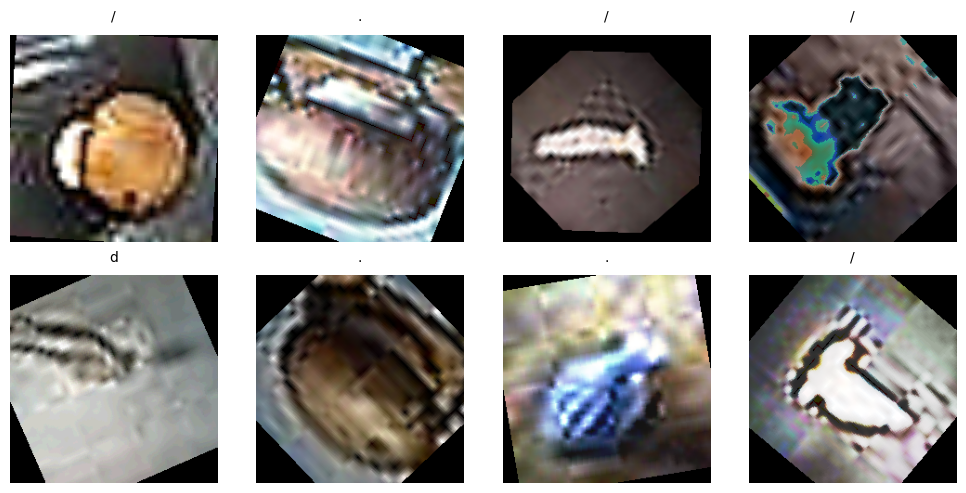

In [115]:
from utils.helper import plot_one_batch

plot_one_batch(train_loader, config['batch_size'], artifact_data_dir)

In [3]:
!python train.py --config ../config/exp.yaml

args Namespace(model='alexnet', config='../config/exp.yaml', project='hutech_mushroom', dataset='hutech-dataset:latest')
HERE config! {'project': 'hutech_mushroom', 'dataset': 'hutech-dataset:latest', 'model': 'vit', 'pretrained': False, 'freeze': False, 'resize': 224, 'random_crop': 224, 'horizontal_flip': 0.5, 'vertical_flip': 0.5, 'zoom_range': [0.8, 1.2], 'random_rotation': 180, 'random_affine': 0.2, 'random_perspective': 0.2, 'auto_aug': 1, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'random_erasing': 0.3, 'scheduler': 'step', 'es_patience': 10, 'num_classes': 4, 'lr': '1e-5', 'num_epochs': 150, 'batch_size': 16, 'optimizer': 'adamw', 'weight_decay': 0.0001, 'momentum': 0.9}
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: beehappy2554 (beehappy2554-bosch-global) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ creating run (0.2s)
wandb: ⣻ cre